Use This Script to Visualize The Features of Some of the Data

In [10]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display

from IPython import display
from matplotlib import pyplot

In [4]:
# A simple wrapper class for (1-channel) audio data
# data is a 1-D NumPy array containing the data
# rate is a number expressing the samples per second
class Audio:
    def __init__(self, data, rate):
        self.data = data
        self.rate = rate
    def play(self):
        return display.Audio(self.data, rate=self.rate)
    def plot_wave(self):
        librosa.display.waveplot(self.data, sr=self.rate)
    def plot_spectrum(self):
        n_fft = int(self.rate / 20)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(self.data, n_fft)), ref=np.max)
        librosa.display.specshow(D, y_axis='linear', sr=self.rate, hop_length=n_fft/4)
    @classmethod
    def fromfile(cls, fn):
        return cls(*librosa.load(fn, sr=None))

In [5]:
# Credit to Yihui Xiong, 2017, https://github.com/xiongyihui/tdoa/blob/master/gcc_phat.py

def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=16):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT)method.
    '''
    
    # make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    n = sig.shape[0] + refsig.shape[0]

    # Generalized Cross Correlation Phase Transform
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    R = SIG * np.conj(REFSIG)

    cc = np.fft.irfft(R / np.abs(R), n=(interp * n))

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # find max cross correlation index
    shift = np.argmax(np.abs(cc)) - max_shift

    tau = shift / float(interp * fs)
    
    return tau, cc

In [7]:
data_dir = os.path.join(os.path.abspath('.'), 'data/raw/')
# 10 subjects
subject_names = ['s' + str(i) for i in range(1,10+1)]

# 2 session rooms
trial_names_base = [f'{t}_trial{i}' 
                    for t in ['downstairs_nowall', 'downstairs_wall',
                              'upstairs_nowall', 'upstairs_wall']
                    for i in range(1,3)]

trial_names = [os.path.join(s, s + '_' + t) 
               for s in subject_names
               for t in trial_names_base]
angle_names = [alph[0] + num[0] + '_' + alph[1] + '_' + num[1]  
               for alph in [('A', '1'), ('B', '3'), ('C', '5')]
               for num in [(str(i),str(45*i)) for i in range(3)]]
# recording paths
recording_paths = [os.path.join(data_dir, t,a) for t in trial_names 
                                              for a in angle_names]
recording_paths_rel = [(s,t,a) for s in subject_names
                               for t in trial_names_base 
                               for a in angle_names]

print(*zip(recording_paths_rel, recording_paths))

(('s1', 'downstairs_nowall_trial1', 'A0_1_0'), '/home/abi/direction_of_voice/data/raw/s1/s1_downstairs_nowall_trial1/A0_1_0') (('s1', 'downstairs_nowall_trial1', 'A1_1_45'), '/home/abi/direction_of_voice/data/raw/s1/s1_downstairs_nowall_trial1/A1_1_45') (('s1', 'downstairs_nowall_trial1', 'A2_1_90'), '/home/abi/direction_of_voice/data/raw/s1/s1_downstairs_nowall_trial1/A2_1_90') (('s1', 'downstairs_nowall_trial1', 'B0_3_0'), '/home/abi/direction_of_voice/data/raw/s1/s1_downstairs_nowall_trial1/B0_3_0') (('s1', 'downstairs_nowall_trial1', 'B1_3_45'), '/home/abi/direction_of_voice/data/raw/s1/s1_downstairs_nowall_trial1/B1_3_45') (('s1', 'downstairs_nowall_trial1', 'B2_3_90'), '/home/abi/direction_of_voice/data/raw/s1/s1_downstairs_nowall_trial1/B2_3_90') (('s1', 'downstairs_nowall_trial1', 'C0_5_0'), '/home/abi/direction_of_voice/data/raw/s1/s1_downstairs_nowall_trial1/C0_5_0') (('s1', 'downstairs_nowall_trial1', 'C1_5_45'), '/home/abi/direction_of_voice/data/raw/s1/s1_downstairs_nowall

In [8]:
recordings_of_interest_0 = [os.path.join(recording_paths[0], f'recording0_0_{i}.wav') for i in range(1,5)]
audio_files_0 = [Audio.fromfile(r) for r in recordings_of_interest_0]
four_channels_0 = [a.data for a in audio_files_0]
gcc_phat_data_0 = [gcc_phat(four_channels_0[i],four_channels_0[j], fs = audio_files_0[0].rate, max_tau=0.236 * 1e-3, interp=1)
     for i in range(len(four_channels_0))
     for j in range(i+1,len(four_channels_0))]

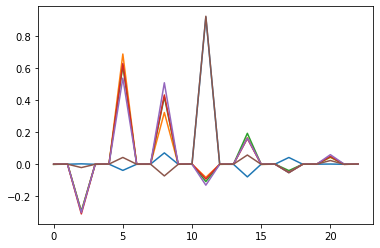

In [9]:
for i in range(len(gcc_phat_data_0)):
    pyplot.plot(gcc_phat_data_0[i][1])